In [14]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV,ElasticNetCV
from pyentrp import entropy as pyent
import EntropyHub as EH
import neurokit2 as nk
import random
import sampen
import requests
import io
import apache_log_parser
from pprint import pprint
import os
from sklearn import preprocessing
from typing import List
import itertools

In [2]:
df_S = pd.read_csv(f"{os.getcwd()}/wc_day73.csv")
df_S["date"] = pd.to_datetime(df_S["date"])
df_S

,index,date,count
0,0,1998-07-06 22:00:01,68
1,1,1998-07-06 22:00:02,125
2,2,1998-07-06 22:00:03,108
3,3,1998-07-06 22:00:04,139
4,4,1998-07-06 22:00:05,171
...,...,...,...
105551,105551,1998-07-08 03:19:12,223
105552,105552,1998-07-08 03:19:13,203
105553,105553,1998-07-08 03:19:14,211
105554,105554,1998-07-08 03:19:15,199


In [3]:
df_6S = df_S.groupby(pd.Grouper(key="date", freq="6S")).sum().reset_index()
df_6S

,date,index,count
0,1998-07-06 22:00:00,10,611
1,1998-07-06 22:00:06,45,1135
2,1998-07-06 22:00:12,81,1068
3,1998-07-06 22:00:18,117,1113
4,1998-07-06 22:00:24,153,1135
...,...,...,...
17588,1998-07-08 03:18:48,633177,1123
17589,1998-07-08 03:18:54,633213,1150
17590,1998-07-08 03:19:00,633249,1212
17591,1998-07-08 03:19:06,633285,1240


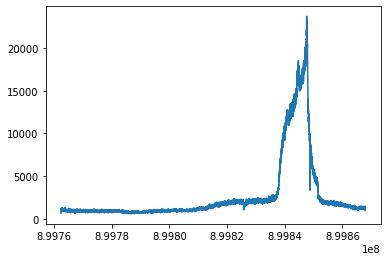

In [4]:
df_6S_date = (pd.to_datetime(df_6S["date"]).astype(int) / 10**9).array.reshape(-1, 1)
df_6S_count = df_6S["count"].array.reshape(-1, 1)
plt.plot(df_6S_date, df_6S_count)

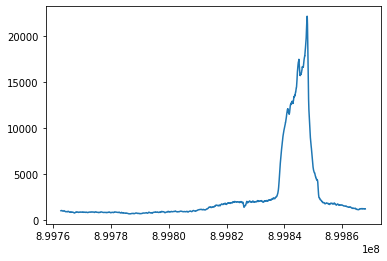

In [5]:
df_6S_date = (pd.to_datetime(df_6S["date"]).astype(int) / 10**9).array.reshape(-1, 1)
df_6S_rolling_count = df_6S["count"].rolling(60).mean().array.reshape(-1, 1)
plt.plot(df_6S_date, df_6S_rolling_count)

In [7]:
### Range distance for RangeEn_B and RangeEn_A
def dist_range(x, y):
  return (np.max(np.abs(x - y), axis=1) - np.min(np.abs(x - y), axis=1)) / (np.max(np.abs(x - y), axis=1) + np.min(np.abs(x - y), axis=1))

### RangeEn-A (mApEn)
def RangeEn_A(x, emb_dim=2, tolerance=.2, dist=dist_range):

    n = np.shape(x)
    n = np.max(n)

    tVecs = np.zeros((n - emb_dim, emb_dim + 1))
    for i in range(tVecs.shape[0]):
        tVecs[i, :] = x[i:i + tVecs.shape[1]]
    counts = []
    for m in [emb_dim, emb_dim + 1]:
        # get the matrix that we need for the current m
        tVecsM = tVecs[:n - m + 1, :m]
        # successively calculate distances between each pair of template vectors
        C = []
        for i in range(len(tVecsM)):
            dsts = dist(tVecsM, tVecsM[i])
            # delete undefined distances coming from zero segments
            # dsts = [x for i, x in enumerate(dsts) if not np.isnan(x) and not np.isinf(x)]
            # count how many 'defined' distances are smaller than the tolerance
            # if(dsts):
            C.append((np.sum(dsts < tolerance)) / (n - m))
        # compute sum of log probabilities
        counts.append((np.sum(np.log(C))) / (n - m))

    RangeEn_A = counts[0] - counts[1]

    return RangeEn_A

##### RangeEn-B (mSampEn)
def RangeEn_B(x, emb_dim=2, tolerance=.2, dist=dist_range):

    n = np.shape(x)
    n = np.max(n)

    tVecs = np.zeros((n - emb_dim, emb_dim + 1))
    for i in range(tVecs.shape[0]):
        tVecs[i, :] = x[i:i + tVecs.shape[1]]
    counts = []
    for m in [emb_dim, emb_dim + 1]:
        counts.append(0)
        # get the matrix that we need for the current m
        tVecsM = tVecs[:n - m + 1, :m]
        # successively calculate distances between each pair of template vectors
        for i in range(len(tVecsM)):
            dsts = dist(tVecsM, tVecsM[i])
            # delete self-matching
            dsts = np.delete(dsts, i, axis=0)
            # delete undefined distances coming from zero segments
            # dsts = [x for i, x in enumerate(dsts) if not np.isnan(x) and not np.isinf(x)]
            # count how many 'defined' distances are smaller than the tolerance
            # if (dsts):
            counts[-1] += np.sum(dsts < tolerance)/(n - m - 1)

    if counts[1] == 0:
        # log would be infinite => cannot determine RangeEn_B
        RangeEn_B = np.nan
    else:
        # compute log of summed probabilities
        RangeEn_B = -np.log(1.0 * counts[1] / counts[0])

    return RangeEn_B

In [8]:
def rangenb_loop(ser: List[float], batch_size = 300) -> List[float]:
    return [RangeEn_B(np.array(ser[index-batch_size:index])) for index in range(len(ser))[batch_size:]]

In [15]:
def df_to_list(df: pd.DataFrame)-> np.ndarray:
    return np.array(list(itertools.chain.from_iterable(df.to_numpy())))

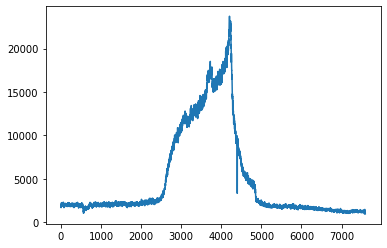

In [27]:
plt.plot(df_6S_count[10000:])

In [28]:
rangenb = rangenb_loop(df_to_list(df_6S_count[10000:]))

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_85127/832245642.py:3: RuntimeWarning: invalid value encountered in true_divide
  return (np.max(np.abs(x - y), axis=1) - np.min(np.abs(x - y), axis=1)) / (np.max(np.abs(x - y), axis=1) + np.min(np.abs(x - y), axis=1))


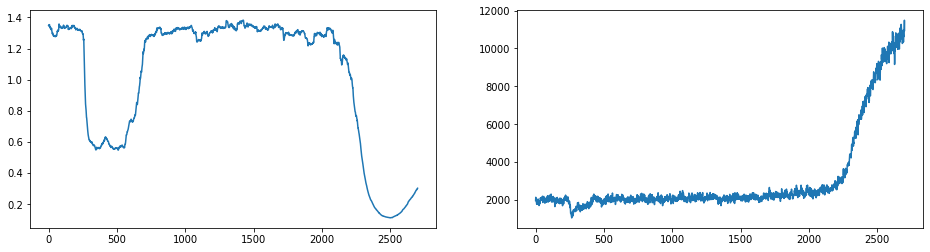

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

axes[0].plot(rangenb)
axes[1].plot(df_6S_count[10300:])